In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

# in those notebook we're going to cover some of the most fundamental concepts of tensorflow

more specifically we're going to cover:
* Intro to tensors
* getting info from tensors
* manipulating tensors
* tensors and numpy
* using @tf.function (a way to speed up your regular python functions
* using gpu with tf
* exercises to try yourself

# Intro to tensors

In [2]:
#import tensorflow
import tensorflow as tf
print(tf.__version__)


2.4.0


### creating tensors with tf.constant()

In [3]:
#create first tensors with tf.constant()

scalar = tf.constant(7)

scalar

<tf.Tensor: shape=(), dtype=int32, numpy=7>

In [4]:
#check ndim of tensor
scalar.ndim

0

In [5]:
#create a vector
vector = tf.constant([10,10])
print(vector)

tf.Tensor([10 10], shape=(2,), dtype=int32)


In [6]:
#check to ndim of vector
vector.ndim

1

In [7]:
#create a matrix
matrix = tf.constant([[10,7],[7,10]])
print(matrix)

tf.Tensor(
[[10  7]
 [ 7 10]], shape=(2, 2), dtype=int32)


In [8]:
#get matrix ndim
matrix.ndim
#the number of elements in a tensors shape represents the number of dimensions

2

In [9]:
#create another matrix with specified dtype
another_matrix = tf.constant([[10.,7.],
                             [3.,2.],
                            [8.,9.]], dtype = tf.float16)
print(another_matrix)
#by default, tensors are created as int32

tf.Tensor(
[[10.  7.]
 [ 3.  2.]
 [ 8.  9.]], shape=(3, 2), dtype=float16)


In [10]:
#what is ndim of another matrix?
another_matrix.ndim

2

In [11]:
#now let's create a tensor
tensor = tf.constant([[[1,2,3],
                      [4,5,6]],
                     [[7,8,9],
                     [10,11,12]],
                     [[13,14,15],
                     [16,17,18]]])
print(tensor)

tf.Tensor(
[[[ 1  2  3]
  [ 4  5  6]]

 [[ 7  8  9]
  [10 11 12]]

 [[13 14 15]
  [16 17 18]]], shape=(3, 2, 3), dtype=int32)


In [12]:
#find tensor number of dimensions
tensor.ndim

3

What we've created so far:
* scalar: a single number
* vector: a number with direction (e.g. wind speed and direction)
* matrix: a 2-d array of numbers
* tensor: an n-dimension array of numbers (where n can be any number. a 0-d tensor is scalar, a 1-d tensor is a vector

### create tensors with tf.Variable()

The `Variable()` constructor requires an initial value for the variable, which
can be a `Tensor` of any type and shape. This initial value defines the type
and shape of the variable. After construction, the type and shape of the
variable are fixed. The value can be changed using one of the assign methods.

In [13]:
changeable_tensor = tf.Variable([10,7])
unchangeable_tensor = tf.constant([10,7])
changeable_tensor, unchangeable_tensor
#notice output of changeable_tensor is tf.Variable 'Variable:0' shape=(2,)

(<tf.Variable 'Variable:0' shape=(2,) dtype=int32, numpy=array([10,  7])>,
 <tf.Tensor: shape=(2,), dtype=int32, numpy=array([10,  7])>)

In [14]:
#let's change the values of changeable_tensor
#changeable_tensor[0] = 7   #this throws an error
#changeable_tensor
changeable_tensor[0].assign(7)
changeable_tensor

<tf.Variable 'Variable:0' shape=(2,) dtype=int32, numpy=array([7, 7])>

In [15]:
#now let's try changing a value of unchangeable_tensor
#unchangeable_tensor[0] = 7   
#unchangeable_tensor[0].assign(7)
#by of these throw errors
#tensorflow.python.framework.ops.EagerTensor' object does not support item assignment
#obviously tf.constant has no .assign() method

rarely in practice will you need to decide whether to use tf.constant or tf.Variable to create tensors, as tf does this for you. however, if in doubt, use tf.constant and chnage it later if needed.

### creating random tensors

* random tensors are tensors of some arbitrary size which contain random numbers.
* random numbers are generally used to intialize weights in neural networks.
* as the nn sees more examples of the data it begins to change these random weights to better predict the outputs

In [16]:
#create 2 random tensors
random1 = tf.random.Generator.from_seed(42)
random1 = random1.normal(shape = (3,2))
random1

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.7565803 , -0.06854702],
       [ 0.07595026, -1.2573844 ],
       [-0.23193765, -1.8107855 ]], dtype=float32)>

In [17]:
random2 = tf.random.Generator.from_seed(42)
random2 = random2.uniform(shape = (3,2))
random2

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.7493447 , 0.73561966],
       [0.45230794, 0.49039817],
       [0.1889317 , 0.52027524]], dtype=float32)>

In [18]:
random3 = tf.random.uniform(shape = (3,2))
random3

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.4084915 , 0.16175425],
       [0.29083335, 0.02440453],
       [0.68619883, 0.8303734 ]], dtype=float32)>

### shuffling the order of tensors

In [19]:
#why shuffle order of tensors?
#if we have a bunch of photos of ramen and a bunch of photos
#of spaghetti, we don't want to train the model on the first
#1000 images that are all ramen first and then the last 500
#images that are spaghetti. We want to randomize the order in which
#the images are trained so the model can adjust weights to account
#for both types of images at the same time

In [20]:
not_shuffled = tf.constant([[10,7],
                            [3,4],
                            [2,5]])

In [21]:
not_shuffled.ndim, not_shuffled.shape

(2, TensorShape([3, 2]))

tf.random.shuffle randomly shuffles a tensor along its first dimension

In [22]:
shuffled = tf.random.shuffle(not_shuffled)
not_shuffled, shuffled

(<tf.Tensor: shape=(3, 2), dtype=int32, numpy=
 array([[10,  7],
        [ 3,  4],
        [ 2,  5]])>,
 <tf.Tensor: shape=(3, 2), dtype=int32, numpy=
 array([[ 3,  4],
        [10,  7],
        [ 2,  5]])>)

* the values in each row statys the same, the only thing that changes is the order of the rows themselves
* 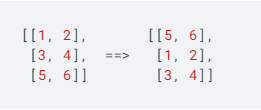

### Other ways to create tensors

In [23]:
#ones
tf.ones(shape = (3,2))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.],
       [1., 1.]], dtype=float32)>

In [24]:
#zeroes
tf.zeros(shape = (10,7))

<tf.Tensor: shape=(10, 7), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

### Turn NP arrays into tensors

the main difference between np arrays and tf tensors are that tensors can be run on a gpu much faster for numerical computing

In [25]:
#tensors from np arrays
numpy_A = np.arange(1,25, dtype = np.int32)
numpy_A

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [26]:
A = tf.constant(numpy_A)
A

<tf.Tensor: shape=(24,), dtype=int32, numpy=
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])>

In [27]:
B = tf.constant(numpy_A, shape = (2,3,4))
B

<tf.Tensor: shape=(2, 3, 4), dtype=int32, numpy=
array([[[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]],

       [[13, 14, 15, 16],
        [17, 18, 19, 20],
        [21, 22, 23, 24]]])>

### Getting info from  your tensors (attributes)
* shape - the length (number of elements) of each of the dimensions of a tensor.  tensor.shape
* rank - the number of tensor dimensions. A scalar has rank 0, a vector has rank 1, a matrix is rank 2.  tensor.ndim
* axis or dimension - a particular dimension of a tensor.  tensor[0], tensor[:,1]...
* size - the total number of itens in the tensor.   tf.size(tensor)

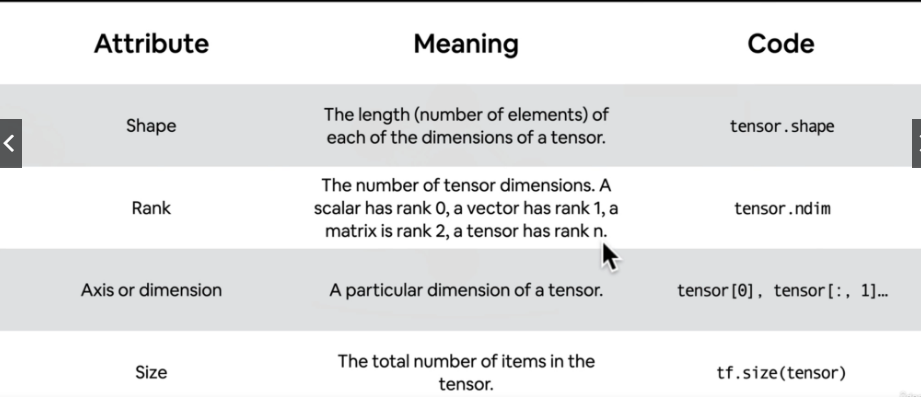

In [28]:
#create a rank 4 tensor
rank4_tensor = tf.zeros(shape = (2,3,4,5))
rank4_tensor

<tf.Tensor: shape=(2, 3, 4, 5), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]],


       [[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]]], dtype=float32)>

In [29]:
rank4_tensor[0]

<tf.Tensor: shape=(3, 4, 5), dtype=float32, numpy=
array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]], dtype=float32)>

In [30]:
rank4_tensor.shape, rank4_tensor.ndim, tf.size(rank4_tensor)

(TensorShape([2, 3, 4, 5]), 4, <tf.Tensor: shape=(), dtype=int32, numpy=120>)

In [31]:
print("Datatype of every element: ", rank4_tensor.dtype)
print("number of dimensions: ", rank4_tensor.ndim)
print('shape of tensor: ', rank4_tensor.shape)
print('elements along 0 axis: ', rank4_tensor.shape[0])
print('elements along last axis: ', rank4_tensor.shape[-1])
print('total number of elements in tensor: ', tf.size(rank4_tensor))

Datatype of every element:  <dtype: 'float32'>
number of dimensions:  4
shape of tensor:  (2, 3, 4, 5)
elements along 0 axis:  2
elements along last axis:  5
total number of elements in tensor:  tf.Tensor(120, shape=(), dtype=int32)


### Indexing and Expanding Tensors

tensors can be indexed just like python lists

In [32]:
#get the first 2 elements of each dimension
rank4_tensor[:2,:2,:2,:2]

<tf.Tensor: shape=(2, 2, 2, 2), dtype=float32, numpy=
array([[[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]]], dtype=float32)>

In [33]:
#get the first element from each dimension from each index except the last one
rank4_tensor[:1,:1,:1,:]

<tf.Tensor: shape=(1, 1, 1, 5), dtype=float32, numpy=array([[[[0., 0., 0., 0., 0.]]]], dtype=float32)>

In [34]:
rank4_tensor[:1,:1,:,:1]

<tf.Tensor: shape=(1, 1, 4, 1), dtype=float32, numpy=
array([[[[0.],
         [0.],
         [0.],
         [0.]]]], dtype=float32)>

In [35]:
#lets add an extra dimension to the end of the tensor
rank2_tensor = tf.constant([[10,7],
                           [3,4]])
rank2_tensor.shape, rank2_tensor.ndim, tf.size(rank2_tensor)


#get the last item of each row
rank2_tensor[:,-1]

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([7, 4])>

In [36]:
#add in an extra dimension to rank2_tensor
rank3 = rank2_tensor[..., tf.newaxis]
rank3
#... means to every axis

<tf.Tensor: shape=(2, 2, 1), dtype=int32, numpy=
array([[[10],
        [ 7]],

       [[ 3],
        [ 4]]])>

In [37]:
#alternative to tf.newaxis is tf.expand(dims)
tf.expand_dims(rank2_tensor, axis = -1)

<tf.Tensor: shape=(2, 2, 1), dtype=int32, numpy=
array([[[10],
        [ 7]],

       [[ 3],
        [ 4]]])>

In [38]:
tf.expand_dims(rank2_tensor, axis = 0)

<tf.Tensor: shape=(1, 2, 2), dtype=int32, numpy=
array([[[10,  7],
        [ 3,  4]]])>

### Manipulating Tensors (tensor operations)

**basic operations**
**+,-, *, /**

In [39]:
#you can add values to a tensors using the addition operator
tensor = tf.constant([[10,7],[3,4]])
tensor+10
#applies the 10 to every value of the tensor

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[20, 17],
       [13, 14]])>

In [40]:
tensor - 2
#subtracts 2 from every element of the tensor

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[8, 5],
       [1, 2]])>

In [41]:
tensor*3
#multiplies every element by 3

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[30, 21],
       [ 9, 12]])>

In [42]:
tensor
#original tensor still remains the same unless you actually set it = to itself

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[10,  7],
       [ 3,  4]])>

In [43]:
#tensor flow has functions that do the same thing with the tf library
tf.multiply(tensor, 3)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[30, 21],
       [ 9, 12]])>

This tf.math functions actually run faster on tensors than the standard pythong math symbols. especially when run on a gpu. should always use the tf library functions if possible.

### Matrix Multiplication w/ Tensors Pt1

in machine learning, matrix multiplication is one of the most common tensor operations

* uses the tf.linalg.matmul() function

* there are 2 rules are tensors must fulfill if we're going to matrix multiply them:
1. the inner dimensions must match
2. the resulting matrix has the shape of the outer dimensions

In [44]:
t1 = tf.constant([[1,2,3],[4,5,6]])
t2 = tf.constant([[7,8],[9,10],[11,12]])
t1,t2

(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
 array([[1, 2, 3],
        [4, 5, 6]])>,
 <tf.Tensor: shape=(3, 2), dtype=int32, numpy=
 array([[ 7,  8],
        [ 9, 10],
        [11, 12]])>)

In [45]:
tf.matmul(t1,t2)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 58,  64],
       [139, 154]])>

In [46]:
#matrix multiplication with Python operation "@"
t1@t2

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 58,  64],
       [139, 154]])>

the example below shows what happens when the tensors aren't compatible for matmul. we also cover how to modify the shape of the second tensor to allow for matmul

* 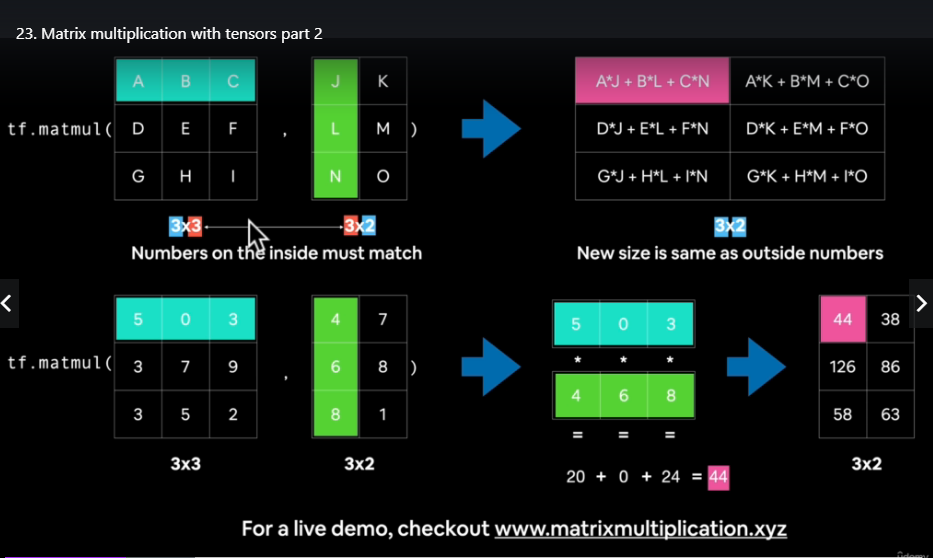


In [47]:
tensor1 = tf.constant([[1,2],[3,4],[5,6]])
tensor2 = tf.constant([[7,8], [9,10],[11,12]])
tf.matmul(tensor1, tensor2)

InvalidArgumentError: Matrix size-incompatible: In[0]: [3,2], In[1]: [3,2] [Op:MatMul]

In [48]:
tensor1.shape, tensor2.shape

(TensorShape([3, 2]), TensorShape([3, 2]))

In [49]:
tf.matmul(tensor1, tf.reshape(tensor2, shape = (2,3)))

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 27,  30,  33],
       [ 61,  68,  75],
       [ 95, 106, 117]])>

In [50]:
#this also works with the transpose method
tf.matmul(tensor1, tf.transpose(tensor2))

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 23,  29,  35],
       [ 53,  67,  81],
       [ 83, 105, 127]])>

In [51]:
tensor2

<tf.Tensor: shape=(3, 2), dtype=int32, numpy=
array([[ 7,  8],
       [ 9, 10],
       [11, 12]])>

In [52]:
tf.reshape(tensor1, (2,3))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 2, 3],
       [4, 5, 6]])>

In [53]:
tf.matmul(tf.reshape(tensor1, (2,3)), tensor2)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 58,  64],
       [139, 154]])>

can do the same thing with transpose as you can do with reshape with 1 caveat. transpose flips the axis while reshape shuffles the tensor around

In [54]:
tensor1, tf.transpose(tensor1), tf.reshape(tensor1, shape = (2,3))

(<tf.Tensor: shape=(3, 2), dtype=int32, numpy=
 array([[1, 2],
        [3, 4],
        [5, 6]])>,
 <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
 array([[1, 3, 5],
        [2, 4, 6]])>,
 <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
 array([[1, 2, 3],
        [4, 5, 6]])>)

In [55]:
#try matmul with transpose rather than reshape
tf.matmul(tf.transpose(tensor1), tensor2)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 89,  98],
       [116, 128]])>

**The Dot Product**
matrix multiplication is also referred to as the dot product.
you can perform matrix mult using: 
* tf.matmul()
* tf.tensordot()

In [56]:
X = tf.constant([[1,2], [3,4], [5,6]])
Y = tf.constant([[7,8],[9,10],[11,12]])
X, Y

(<tf.Tensor: shape=(3, 2), dtype=int32, numpy=
 array([[1, 2],
        [3, 4],
        [5, 6]])>,
 <tf.Tensor: shape=(3, 2), dtype=int32, numpy=
 array([[ 7,  8],
        [ 9, 10],
        [11, 12]])>)

In [57]:
tf.transpose(Y), tf.reshape(Y, shape = (2,3))

(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
 array([[ 7,  9, 11],
        [ 8, 10, 12]])>,
 <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
 array([[ 7,  8,  9],
        [10, 11, 12]])>)

In [58]:
#perform dot product on x and y (requires x or y to be transposed)
#lets transpose y and reshape y to see how the results differ
print(tf.matmul(X, tf.transpose(Y)))
print(tf.matmul(X, tf.reshape(Y, shape = (2,3))))

tf.Tensor(
[[ 23  29  35]
 [ 53  67  81]
 [ 83 105 127]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[ 27  30  33]
 [ 61  68  75]
 [ 95 106 117]], shape=(3, 3), dtype=int32)


in most cases these operations are done behind the scenes. however, if you need to change a tensor to allow for matmul you will most likely use transpose over reshape.

### Changing DataType of tensors

In [59]:
#the data type of most tensors will be int32 depending on how they're created.
#soemtimes we want to change the dtype

In [60]:
B = tf.constant([1.7, 7.4])
B, B.dtype

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.7, 7.4], dtype=float32)>,
 tf.float32)

In [61]:
C = tf.constant([7,10])
C.dtype

tf.int32

In [62]:
#change from float 32 to float 16 (reduced precision)
D = tf.cast(B, dtype = tf.float16)
D, D.dtype

(<tf.Tensor: shape=(2,), dtype=float16, numpy=array([1.7, 7.4], dtype=float16)>,
 tf.float16)

Mixed precision is the use of both 16-bit and 32-bit floating-point types in a model during training to make it run faster and use less memory. By keeping certain parts of the model in the 32-bit types for numeric stability, the model will have a lower step time and train equally as well in terms of the evaluation metrics such as accuracy. This guide describes how to use the Keras mixed precision API to speed up your models. Using this API can improve performance by more than 3 times on modern GPUs and 60% on TPUs.

Today, most models use the float32 dtype, which takes 32 bits of memory. However, there are two lower-precision dtypes, float16 and bfloat16, each which take 16 bits of memory instead. Modern accelerators can run operations faster in the 16-bit dtypes, as they have specialized hardware to run 16-bit computations and 16-bit dtypes can be read from memory faster.

NVIDIA GPUs can run operations in float16 faster than in float32, and TPUs can run operations in bfloat16 faster than float32. Therefore, these lower-precision dtypes should be used whenever possible on those devices. However, variables and a few computations should still be in float32 for numeric reasons so that the model trains to the same quality. The Keras mixed precision API allows you to use a mix of either float16 or bfloat16 with float32, to get the performance benefits from float16/bfloat16 and the numeric stability benefits from float32.


In [63]:
#change from int32 to float 32
E = tf.cast(C, dtype = tf.float32)
E, E.dtype

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 7., 10.], dtype=float32)>,
 tf.float32)

In [64]:
#and convert int32 to float 16
F = tf.cast(B, dtype = tf.float16)
F, F.dtype

(<tf.Tensor: shape=(2,), dtype=float16, numpy=array([1.7, 7.4], dtype=float16)>,
 tf.float16)

### Tensor Aggregation (finding min, max, mean, and more)

aggregating tensors is condesning them from multiple values down to a smaller amount of values

* abs
* min
* max
* mean
* sum

In [65]:
#getting the absolute values
D = tf.constant([-7, -10])
tf.abs(D)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 7, 10])>

In [66]:
#create a random tensor values between 0 and 100 or size 50
E = tf.constant(np.random.randint(0, 100, size = 50))
E, tf.size(E), E.shape, E.ndim


(<tf.Tensor: shape=(50,), dtype=int32, numpy=
 array([45, 87, 18, 82, 86, 44, 19, 99, 74, 58, 68, 71, 89, 23, 75,  1, 50,
         8, 97,  7, 62, 26, 53, 49, 35, 60, 36, 32, 33, 19, 57, 64, 38, 43,
        84, 74, 80, 49, 34, 68,  0, 18, 92, 14,  0, 88, 13, 61, 99, 91])>,
 <tf.Tensor: shape=(), dtype=int32, numpy=50>,
 TensorShape([50]),
 1)

In [67]:
#find min
tf.reduce_min(E)  #returns a 0

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [68]:
#find max
tf.reduce_max(E)   #returns 99

<tf.Tensor: shape=(), dtype=int32, numpy=99>

In [69]:
#find mean
tf.reduce_mean(E)  #returns mean of 51

<tf.Tensor: shape=(), dtype=int32, numpy=51>

In [70]:
#find sum
tf.reduce_sum(E)

<tf.Tensor: shape=(), dtype=int32, numpy=2573>

In [71]:
#find variance
tf.math.reduce_variance(tf.cast(E, dtype = tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=862.16846>

In [72]:
#find std
tf.math.reduce_std(tf.cast(E, dtype = tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=29.362705>

### find positional max and min (argmax, argmin)

* helpful when nn outputs prediction probabilities
* at which index of the tensor row is the maximum and minimum

In [73]:
#create a new tensor for finding positional min and max
tf.random.set_seed(42)
F = tf.random.uniform(shape = [50])
F

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([0.6645621 , 0.44100678, 0.3528825 , 0.46448255, 0.03366041,
       0.68467236, 0.74011743, 0.8724445 , 0.22632635, 0.22319686,
       0.3103881 , 0.7223358 , 0.13318717, 0.5480639 , 0.5746088 ,
       0.8996835 , 0.00946367, 0.5212307 , 0.6345445 , 0.1993283 ,
       0.72942245, 0.54583454, 0.10756552, 0.6767061 , 0.6602763 ,
       0.33695042, 0.60141766, 0.21062577, 0.8527372 , 0.44062173,
       0.9485276 , 0.23752594, 0.81179297, 0.5263394 , 0.494308  ,
       0.21612847, 0.8457197 , 0.8718841 , 0.3083862 , 0.6868038 ,
       0.23764038, 0.7817228 , 0.9671384 , 0.06870162, 0.79873943,
       0.66028714, 0.5871513 , 0.16461694, 0.7381023 , 0.32054043],
      dtype=float32)>

In [74]:
tf.argmax(F)  #returns the index position 42

<tf.Tensor: shape=(), dtype=int64, numpy=42>

In [75]:
# lets look at that index position 42
F[tf.argmax(F)]  #which returns .9671384

<tf.Tensor: shape=(), dtype=float32, numpy=0.9671384>

In [76]:
#we can compare that to the max value of the tensor
tf.reduce_max(F)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9671384>

In [77]:
tf.argmin(F)   #returns index value of 16

<tf.Tensor: shape=(), dtype=int64, numpy=16>

In [78]:
#so we'll look at index 16 of the tensor
F[tf.argmin(F)]   #which returns 0.009463668

<tf.Tensor: shape=(), dtype=float32, numpy=0.009463668>

In [79]:
#we ccompare this value to the min value
tf.reduce_min(F)

<tf.Tensor: shape=(), dtype=float32, numpy=0.009463668>

In [80]:
#what about 2d tensors
F = tf.random.uniform(shape = (5,3))
F

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.68789124, 0.48447883, 0.9309944 ],
       [0.252187  , 0.73115396, 0.89256823],
       [0.94674826, 0.7493341 , 0.34925628],
       [0.54718256, 0.26160395, 0.69734323],
       [0.11962581, 0.53484344, 0.7148968 ]], dtype=float32)>

In [81]:
tf.argmax(F)
#returns an array with the index of the max value of each column

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([2, 2, 0], dtype=int64)>

In [82]:
tf.argmax(F, axis = 1)
#returns an array containiung the index of the max value in each row.

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([2, 2, 0, 2, 2], dtype=int64)>

### Squeezing a tensor (removing all 1-dimension axes)

In [83]:
#create a tensor
tf.random.set_seed(42)
G = tf.constant(tf.random.uniform(shape = [50]), shape = (1,1,1,1,50))
G

<tf.Tensor: shape=(1, 1, 1, 1, 50), dtype=float32, numpy=
array([[[[[0.6645621 , 0.44100678, 0.3528825 , 0.46448255, 0.03366041,
           0.68467236, 0.74011743, 0.8724445 , 0.22632635, 0.22319686,
           0.3103881 , 0.7223358 , 0.13318717, 0.5480639 , 0.5746088 ,
           0.8996835 , 0.00946367, 0.5212307 , 0.6345445 , 0.1993283 ,
           0.72942245, 0.54583454, 0.10756552, 0.6767061 , 0.6602763 ,
           0.33695042, 0.60141766, 0.21062577, 0.8527372 , 0.44062173,
           0.9485276 , 0.23752594, 0.81179297, 0.5263394 , 0.494308  ,
           0.21612847, 0.8457197 , 0.8718841 , 0.3083862 , 0.6868038 ,
           0.23764038, 0.7817228 , 0.9671384 , 0.06870162, 0.79873943,
           0.66028714, 0.5871513 , 0.16461694, 0.7381023 , 0.32054043]]]]],
      dtype=float32)>

In [84]:
tf.squeeze(G)
#the squeeze method removes all the 1 dimenaion axes 
#(aka removes all the extra brackets)

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([0.6645621 , 0.44100678, 0.3528825 , 0.46448255, 0.03366041,
       0.68467236, 0.74011743, 0.8724445 , 0.22632635, 0.22319686,
       0.3103881 , 0.7223358 , 0.13318717, 0.5480639 , 0.5746088 ,
       0.8996835 , 0.00946367, 0.5212307 , 0.6345445 , 0.1993283 ,
       0.72942245, 0.54583454, 0.10756552, 0.6767061 , 0.6602763 ,
       0.33695042, 0.60141766, 0.21062577, 0.8527372 , 0.44062173,
       0.9485276 , 0.23752594, 0.81179297, 0.5263394 , 0.494308  ,
       0.21612847, 0.8457197 , 0.8718841 , 0.3083862 , 0.6868038 ,
       0.23764038, 0.7817228 , 0.9671384 , 0.06870162, 0.79873943,
       0.66028714, 0.5871513 , 0.16461694, 0.7381023 , 0.32054043],
      dtype=float32)>

### One-hot encoding tensors

representing categorical data as numerical data
* red, green, blue
* 1, 0, 0
* 0, 1, 0
* 0, 0, 1

In [85]:
#create a list of indices
some_list = [0, 1, 2, 3] # could be red, green, blue, purple

#one hot encode our list
tf.one_hot(some_list, depth = 4)  #depth is the number of columns returned in the encoding

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)>

In [86]:
#specify custome values for one hot encoding
tf.one_hot(some_list, depth = 4, on_value = 'on value', off_value = 'suck it')

<tf.Tensor: shape=(4, 4), dtype=string, numpy=
array([[b'on value', b'suck it', b'suck it', b'suck it'],
       [b'suck it', b'on value', b'suck it', b'suck it'],
       [b'suck it', b'suck it', b'on value', b'suck it'],
       [b'suck it', b'suck it', b'suck it', b'on value']], dtype=object)>

### Trying out more tensor math operations

* squaring, log, square root

In [87]:
#create a new tensor
H = tf.range(1,10)
H

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([1, 2, 3, 4, 5, 6, 7, 8, 9])>

In [88]:
tf.square(H)

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([ 1,  4,  9, 16, 25, 36, 49, 64, 81])>

In [89]:
#looks like we'll have to convert H into a float to take the sqrt
tf.sqrt(tf.cast(H, tf.float32))

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([1.       , 1.4142135, 1.7320508, 2.       , 2.236068 , 2.4494898,
       2.6457512, 2.828427 , 3.       ], dtype=float32)>

In [90]:
#also need to cast H into a float for log
tf.math.log(tf.cast(H, tf.float32))

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([0.       , 0.6931472, 1.0986123, 1.3862944, 1.609438 , 1.7917595,
       1.9459102, 2.0794415, 2.1972246], dtype=float32)>

### Exploring tf and np compatibility


tf interacts beautifully with np arrays

In [91]:
# create a tensor directly from an np array
J = tf.constant(np.array([3., 7., 10.]))
J

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 3.,  7., 10.])>

In [92]:
#convert tensor back to an np array
np.array(J), type(np.array(J))

(array([ 3.,  7., 10.]), numpy.ndarray)

In [93]:
#can also use the numpy() method to convert tensor back to np array
J.numpy(), type(J.numpy())

(array([ 3.,  7., 10.]), numpy.ndarray)

In [94]:
#sometimes tf lacks the funcationality so it works really well to convert a tensor to np array

In [95]:
#the default types of each are slightly different
numpy_J = tf.constant(np.array([3.,7.,10.]))
tensor_J = tf.constant([3.,7.,10.])
#check dtypes of each
numpy_J.dtype, tensor_J.dtype

(tf.float64, tf.float32)

In [96]:
#default dtype from np array is float63 while if tensor is created from a pytyhon list the dtype
#will be float32

#important because it will error if different dtypes are used 

### Making sure tensors run really fast on GPU

one of the biggest differences between tensor of np array is that tensors can be run on GPUs

In [97]:
#lets check if tf has acces to gpu
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [98]:
#find gpu properties 
!nvidia-smi

Tue Dec 14 12:16:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 466.27       Driver Version: 466.27       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:07:00.0  On |                  N/A |
|  0%   44C    P2    34W / 160W |   5838MiB /  6144MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

If you have access to a CUDA enabled GPU, tensorflow will automatically use it whenever possible!!!